In [4]:
!conda install matplotlib --y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/minoro/anaconda3/envs/tf_gpu

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    cffi-1.14.2                |   py36he30daa8_0         227 KB
    cycler-0.10.0              |           py36_0          13 KB
    dbus-1.13.16               |       hb2f20db_0         501 KB
    expat-2.2.9                |       he6710b0_2         156 KB
    glib-2.65.0                |       h3eb4bd4_0         2.9 MB
    gstreamer-1.14.0           |       hb31296c_0         3.1 MB
    icu-58.2                   |       he6710b0_3        10.5 MB
    kiwisolver-1.2.0           |   py36hfd86e86_0          84 KB
    

In [6]:
import pandas as pd
import numpy as np
import os
import sys
import glob

import tensorflow as tf

%matplotlib inline
%load_ext autoreload
%autoreload 2

physical_devices = tf.config.experimental.list_physical_devices('GPU')

print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[]


In [7]:

IMAGE_SIZE = (224, 224)


In [8]:
IMAGES_DIR = '../../../dataset/imagens'
from pathlib import Path


data = []
for image_path in Path(IMAGES_DIR).rglob('*.jpg'):
    
    if 'anexos' in str(image_path):
        continue
    
    folder_path = os.path.dirname(image_path)
    tipo_documento = os.path.basename(os.path.normpath(folder_path))
    
    data.append({
        'path': str(image_path),
        'tipo': tipo_documento
    })
    
    

In [9]:
df = pd.DataFrame(data)
print(len(df.index))
df.head()

18166


path  \
0  ../../../dataset/imagens/processo_licitatorio_...   
1  ../../../dataset/imagens/processo_licitatorio_...   
2  ../../../dataset/imagens/processo_licitatorio_...   
3  ../../../dataset/imagens/processo_licitatorio_...   
4  ../../../dataset/imagens/processo_licitatorio_...   

                                           tipo  
0   Portaria designando a comissão de licitação  
1  Publicações do aviso do Processo Licitatório  
2  Publicações do aviso do Processo Licitatório  
3  Publicações do aviso do Processo Licitatório  
4  Publicações do aviso do Processo Licitatório

<AxesSubplot:xlabel='tipo'>

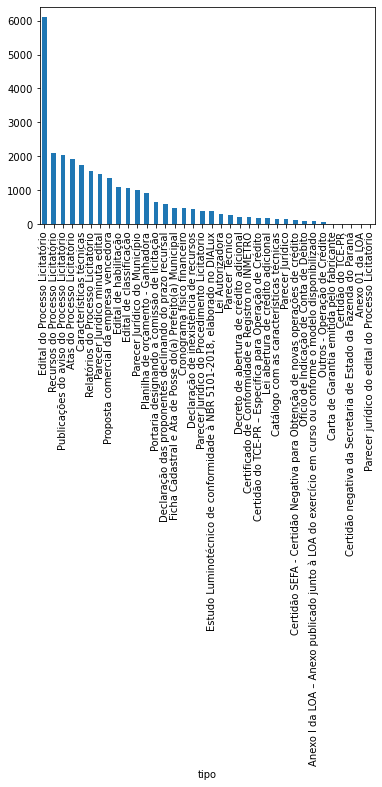

In [8]:
df.groupby('tipo').count()['path'].sort_values(ascending=False).plot(kind='bar')

In [60]:
df.iloc[2].path

'../../dataset/imagens/processo_licitatorio_juridico/Icaraíma - proj 47 - processo 1/Publicações do aviso do Processo Licitatório/Licitação - #190001-2.jpg'

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers, optimizers

datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)
train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    x_col="path",
    y_col="tipo",
    subset="training",
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=IMAGE_SIZE)


valid_generator=datagen.flow_from_dataframe(
    dataframe=df,
    x_col="path",
    y_col="tipo",
    subset="validation",
    color_mode="grayscale",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=IMAGE_SIZE)

Found 13625 validated image filenames belonging to 36 classes.
Found 4541 validated image filenames belonging to 36 classes.


In [76]:
# for x, y in train_generator:
#     print(x, y)
#     sys.exit()
    

In [11]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(36, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 111, 111, 64)      1

In [12]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    epochs=10
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
 18/425 [>.............................] - ETA: 18:12 - loss: 4.1345 - accuracy: 0.0660

KeyboardInterrupt: 